In [1]:
import pycbc
import pandas as pd
from pycbc.psd import interpolate
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
from pycbc.frame import read_frame
from pycbc.detector import Detector

import astropy.units as u
from astropy.coordinates import Distance

import numpy as np

import lal
import lalsimulation
import matplotlib.pyplot as plt
from scipy import signal
import pylab

import matplotlib.pyplot as plt
%matplotlib inline

### Choice of python module for generating SNRs
Assuming I'm going to have mass, spins, redshift, then I can use either:
* pycbc
* gwcosmo

I've used gwcosmo before so I know what to do. BUT it would be useful to get to know how to use pycbc.

If using pycbc, then I need to identify the function that generates the SNRs from these parameters, or otherwise how to go about it.

What I could do is generate a waveform https://pycbc.org/pycbc/latest/html/waveform.html , make some assumptions on localisation and orientation, and basically recreate the gwcosmo method using pycbc.

There's some PyCBC tutorials here:

https://github.com/gwastro/PyCBC-Tutorials/tree/master/tutorial

and on the PyCBC site here is an example for getting SNRs:

https://pycbc.org/pycbc/latest/html/gw150914.html#calculate-the-signal-to-noise

also:

https://colab.research.google.com/github/gwastro/pycbc-tutorials/blob/master/tutorial/4_ChisqSignificance.ipynb



In [2]:
# import the samples
samples = pd.read_csv('params_for_SNR.csv', index_col=0)
samples

,mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2,chi_eff,tilt_1,tilt_2,sin_tilt_1,sin_tilt_2,chi_p,spin1z,spin2z,spin1x,spin2x
0,3.301867,0.992499,0.069194,0.245682,0.704116,0.570399,2.076198,3.277099,0.094257,0.789619,0.963805,0.710085,0.821368,0.200066,0.048720,0.140137,0.049133,0.201795
1,3.614000,0.990344,0.045051,0.032216,0.946914,-0.821554,1.373153,3.579102,0.008264,0.327299,2.534928,0.321486,0.570130,0.018165,0.042659,-0.026467,0.014483,0.018367
2,3.605017,0.993030,0.111428,0.477762,0.648840,0.619204,1.888312,3.579889,0.183675,0.864738,0.903068,0.760925,0.785230,0.372166,0.072299,0.295832,0.084788,0.375153
3,4.564583,0.950299,0.153021,0.114621,0.164766,-0.150329,2.278671,4.337718,0.004532,1.405276,1.721697,0.986333,0.988636,0.150930,0.025213,-0.017231,0.150930,0.113318
4,5.146561,0.962961,0.407271,0.179292,-0.216551,-0.463485,1.956511,4.955935,-0.085695,1.789077,2.052721,0.976271,0.886105,0.397607,-0.088195,-0.083099,0.397607,0.158872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.514865,0.874343,0.180901,0.104812,-0.556798,-0.260817,1.671250,5.696228,-0.066491,2.161322,1.834665,0.830648,0.965388,0.150265,-0.100726,-0.027337,0.150265,0.101184
995,3.607725,0.993575,0.287891,0.516216,0.754180,0.477210,1.246061,3.584545,0.231686,0.716391,1.073319,0.656667,0.878789,0.450316,0.217122,0.246343,0.189049,0.453645
996,3.914876,0.968723,0.232539,0.154071,0.936035,-0.484202,1.890546,3.792432,0.073853,0.359607,2.076247,0.351907,0.874956,0.129998,0.217665,-0.074602,0.081832,0.134805
997,3.083030,0.999738,0.085098,0.046986,0.396827,-0.526999,0.710591,3.082224,0.004508,1.162739,2.125862,0.917894,0.849866,0.078111,0.033769,-0.024762,0.078111,0.039932


For the psd strain info, see:

https://pycbc.org/pycbc/latest/html/pycbc_condition_strain.html?highlight=gwf


from CB for comparing rates https://gw-universe.org/population_model.html

### To be addressed
* All events at one location or uniformly distributed over the sky?
    * handled this in summer project
    * uniform over sky
    * will map sensitivity, can check this
* Set time to cover an observing run?
* The below is for one detector, I will need to combine multiple detectors
* List here the different types of SNR, new SNR...
    * find the optimal SNR
    * also create a waveform and add some gaussian noise
        * <waveform+noise| template>
        * new SNR is goodness of fit chi
        * paper by bruce allen on this
    * check maggiore textbook chapter 7
* Check if my sampled masses are detector frame or not
    * check what the waveform is expecting too
    * expect detector probably
* I need to assume an H0, 70?
    * also the distance conversion, co-moving, look-back, luminosity?
    * https://users.astro.ufl.edu/~guzman/ast6415/spring_16/projects/project01.html 
    * default cosmology is
    * planck 2015
    * david hogg paper on distance measure in cosmology
* PyCBC appears to accept spin1z...and not chi_eff so need to perform a conversion
    * there must be the ability to feed the chi_eff and chi_p ???
    * which angle is tilt, to x,y,z?
    * I have an a_1 and a_2 and a theta_1 and theta_2
    * page 22 of https://arxiv.org/pdf/2010.14533.pdf , chi1 here is a_1 in other works https://arxiv.org/pdf/2001.06051.pdf
    * a1*cos_tilt1 = spin1z, that aligned with orbital angular momentum **check** 
        * confirmed
    * so then the rest of the spin should be in the orbital plane
        * does it matter between x and y? If not then I can just assign all of the rest of the spin to x OR y
        * I **need to** check the PyCBC code to see what it does with spinx and spiny and I can then determine if I can do the above

From the papers, for **spin**:

\begin{align}
\chi_{eff} &=  \frac{S_{1z} \times M_{1} + S_{2z} \times M_{2}}{M_{1} + M_{2}} \space \text{from PyCBC code} \\
&= \frac{M_{1} \vec{a_{1}} + M_{2} \vec{a_{2}}}{M_{1} + M{2}} \hat{L}_{N} \space \text{from paper} \\
&= \frac{M_{1} a_{1}\cos{t_{1}} + M_{2} a_{2}\cos{t_{2}}}{M_{1} + M{2}} \space \text{for t tilt angle between spin and L}\\
&= \frac{\chi_{1}\cos{\theta_{1} + q\chi_{2}\cos{\theta_2}}}{1+q} \space \text{from other paper chi is dimensionless spin}\\
&= \frac{M_{1} \chi_{1}\cos{\theta_{1}} + M_{2} \chi_{2}\cos{\theta_{2}}}{M_{1} + M{2}}\\
\end{align}

so $S_{1z} = a_{1} \times \cos{\theta_{1}}$

so then surely $a_{1} \times \sin{\theta{1}}$ is the dimensionless spin in the x, y plane. As the objects orbit this will oscillate between x and y, so I can say that all of it is initially in x or y.

For $\chi_{p}$ https://journals.aps.org/prd/pdf/10.1103/PhysRevD.91.024043

$\chi_{p} = \text{max}(a_{1}\sin{\theta_{1}}, \frac{4q + 3}{4+3q}qa_{2}\sin{\theta_2})$

what is the factor in front of the second term telling me?

Spin wont change between x and y **look into this**

Draw random number for this

In [3]:
# convert our redshifts into luminosity distances
# samples['dl'] = (samples['redshift']* astropy.cosmology.units.redshift).to(u.Mpc, astropy.cosmoloy.units.redshift_distance(None, kind="luminosity")) 
d = Distance(unit=u.Mpc, z = samples['redshift'], cosmology = None).value
dl = np.asarray(d)
samples = samples.assign(dl = dl)
samples

,mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2,chi_eff,tilt_1,tilt_2,sin_tilt_1,sin_tilt_2,chi_p,spin1z,spin2z,spin1x,spin2x,dl
0,3.301867,0.992499,0.069194,0.245682,0.704116,0.570399,2.076198,3.277099,0.094257,0.789619,0.963805,0.710085,0.821368,0.200066,0.048720,0.140137,0.049133,0.201795,16667.485514
1,3.614000,0.990344,0.045051,0.032216,0.946914,-0.821554,1.373153,3.579102,0.008264,0.327299,2.534928,0.321486,0.570130,0.018165,0.042659,-0.026467,0.014483,0.018367,10039.520769
2,3.605017,0.993030,0.111428,0.477762,0.648840,0.619204,1.888312,3.579889,0.183675,0.864738,0.903068,0.760925,0.785230,0.372166,0.072299,0.295832,0.084788,0.375153,14845.161916
3,4.564583,0.950299,0.153021,0.114621,0.164766,-0.150329,2.278671,4.337718,0.004532,1.405276,1.721697,0.986333,0.988636,0.150930,0.025213,-0.017231,0.150930,0.113318,18665.216600
4,5.146561,0.962961,0.407271,0.179292,-0.216551,-0.463485,1.956511,4.955935,-0.085695,1.789077,2.052721,0.976271,0.886105,0.397607,-0.088195,-0.083099,0.397607,0.158872,15502.887957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.514865,0.874343,0.180901,0.104812,-0.556798,-0.260817,1.671250,5.696228,-0.066491,2.161322,1.834665,0.830648,0.965388,0.150265,-0.100726,-0.027337,0.150265,0.101184,12782.836146
995,3.607725,0.993575,0.287891,0.516216,0.754180,0.477210,1.246061,3.584545,0.231686,0.716391,1.073319,0.656667,0.878789,0.450316,0.217122,0.246343,0.189049,0.453645,8907.007999
996,3.914876,0.968723,0.232539,0.154071,0.936035,-0.484202,1.890546,3.792432,0.073853,0.359607,2.076247,0.351907,0.874956,0.129998,0.217665,-0.074602,0.081832,0.134805,14866.638495
997,3.083030,0.999738,0.085098,0.046986,0.396827,-0.526999,0.710591,3.082224,0.004508,1.162739,2.125862,0.917894,0.849866,0.078111,0.033769,-0.024762,0.078111,0.039932,4465.681675


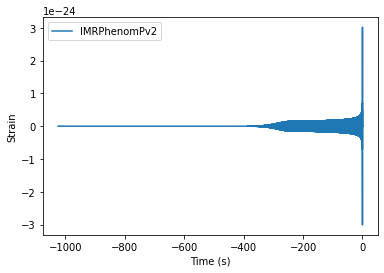

In [4]:


# Time, orientation and location of the source in the sky
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0
end_time = lal.LIGOTimeGPS(0)
# pick real date

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
# fp, fc = d.antenna_pattern(ra, dec, pol, time)
# print("fp={}, fc={}".format(fp, fc))

approximant="IMRPhenomPv2"

# These factors allow us to project a signal into what the detector would
# observe

## Generate a waveform
# i want get_fd_waveform
hp, hc = get_td_waveform(approximant=approximant, mass1=samples['mass_1'][0], mass2=samples['mass_2'][0], spin1x=samples['spin1x'][0], 
                         spin2x = samples['spin2x'][0], spin1z=samples['spin1z'][0], spin2z=samples['spin2z'][0],
                         f_lower=10, delta_t=1.0/4096, inclination=inc,
                         distance=samples['dl'][0])

# ## Apply the factors to get the detector frame strain
# ht = fp * hp + fc * hc


# The projection process can also take into account the rotation of the
# earth using the project wave function.
hp.start_time += end_time
hc.start_time += end_time
ht = d.project_wave(hp, hc, ra, dec, pol)
# frequency domain will change this time aspect

times = np.array(ht.sample_times)

pylab.plot(ht.sample_times, ht, label=approximant)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

In [5]:
print(ht.start_time)

-1023.82421875


/data/wiay/johnny/phd1/phd1/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


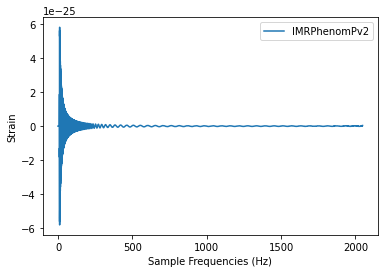

In [6]:
# FFT the waveform into the frequency-domain

ht.start_time = lal.LIGOTimeGPS(ht.start_time)
f_ht = pycbc.waveform.waveform.td_waveform_to_fd_waveform(ht)
pylab.plot(f_ht.sample_frequencies, f_ht, label=approximant)
pylab.ylabel('Strain')
pylab.xlabel('Sample Frequencies (Hz)')
pylab.legend()

The psd file has two columns, frequency and psd (strain?).

I have time-domain strain and frequency domain psd, so this needs corrected.

The length of the two objects is different, I see two options:
* in generating my waveform I can adjust the delta_t or delta_f to change the number of data points
    * reducing the number of data points might make my waveform less accurate
    * this could lead to aliasing? https://en.wikipedia.org/wiki/Aliasing
* I could keep my detla_t or f high and interpolate my psd to create a longer psd array
    * not sure what this could do around a feature like the 480Hz spike
    * can always just compare the two to check

### Notes
#### PSD
My signal should be $s(t) = h(t) + n(t)$ (in time domain) so I need to add gaussian noise.

Noise spectral density: $S_{n}(f) = 2<|\tilde{n}(f)|^{2}>\Delta f$

#### Optimal SNR squared

$<\rho>^2 = \frac{S}{N} ^2 = 4 \int_0^{\inf} df \frac{|\tilde{h}(f0|^2)}{S_{n}(f)}$

TypeError: got an unexpected keyword argument 'axis'

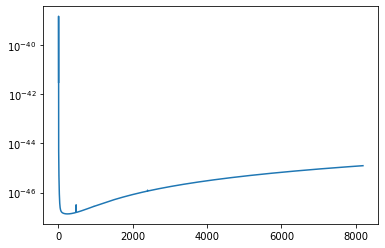

In [7]:
from bilby.gw import detector as det
from bilby.gw import utils
from scipy.interpolate import interp1d

psd_path = '/data/wiay/johnny/phd1/phd1/lib/python3.7/site-packages/bilby/gw/detector/noise_curves/aLIGO_ZERO_DET_high_P_psd.txt'
psd = det.psd.PowerSpectralDensity.from_power_spectral_density_file(psd_path)
#psd_data = psd.data
psd_array = np.genfromtxt(psd_path)

plt.semilogy(psd_array[:,0],psd_array[:,1])
# plt.xlim((10,600))
# plt.ylim((10**-48,10**-46))

psd_interp_fn = interp1d(psd_array[:,0], psd_array[:,1])
# x = np.where(f_ht.sample_frequencies>10, f_ht.sample_frequencies, 0)
# print(x)
gt_10_loc = np.where(f_ht.sample_frequencies>10)[0][0]
psd_interpolated = psd_interp_fn(f_ht.sample_frequencies[gt_10_loc:])

snr = utils.optimal_snr_squared(signal=f_ht[gt_10_loc:], power_spectral_density=psd_interpolated, duration=(ht.sample_times[-1]-ht.sample_times[0]))

Currently my f_ht.sample_frequencies go from 0 to 2048, but my psd goes from 9 to 8000. So the interpolation function can't handle the frequencies between 0 and 9.
* solved but new axis issue

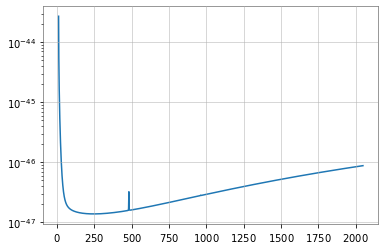

In [ ]:
plt.semilogy(f_ht.sample_frequencies[value:],psd_interpolated)

### Try this next

Wei Changfeng's git may have some useful examples,

https://gilsay.physics.gla.ac.uk/gitlab/wei.changfeng/weichangfeng_project/wikis/home

**To do:**
* check how much difference an increased sampling frequency makes on the ultimate SNR
    * max freq will be half sampling_freq
    * plus safety factor
* duration
    * inspiral length +2s
    * nominally for merger and ringdown
    * work in powers of 2 (bayeswave psds)
    * need a simple way of determining the chirp length in order to control this
* what are:
    * phi_12: Azimuthal angle between the two component spins
    * phi_jl: Azimuthal angle between the total binary angular momentum and the orbital angular momentum
        * wobbles with precession so changes
        * phi in orbital plane
        * uniform on 0,2pi or -pi,pi
    * theta_jn: Angle between the total binary angular momentum and the line of sight
        * this looks like the inclination, no this is theta_ln, iota
        * j is total ang mom
        * jn is angle between j and n(los)
        * uniform in cos, isotropic rather than uniform , on 0, pi
    * psi, polarisation
        * uniform
    * phi, phase
        * uniform
        * degeneracy between these
* check and plot the psd
* duration is currently 1 second
    * this produced an error for being a lower length of time in the detector than the length of the waveform
    * for a waveform of 42.7 seconds, a duration of 50 and 100 both produce the same SNR (3sf)
        * a little off from lal
        * this should be more accurate
        * peters and mathews inspiral papers 1963, 64
* also look into the reference frequency
* parallelising on condor
    * notes should already be on the git site

14:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:48 bilby INFO    : Injected signal in H1:
14:48 bilby INFO    :   optimal SNR = 180626.91
14:48 bilby INFO    :   matched filter SNR = 180627.19+0.14j
14:48 bilby INFO    :   mass_1 = 33.018668523781464
14:48 bilby INFO    :   mass_2 = 32.77099478069958
14:48 bilby INFO    :   a_1 = 0.0691935905869395
14:48 bilby INFO    :   a_2 = 0.2456821228607716
14:48 bilby INFO    :   tilt_1 = 0.7896186501939829
14:48 bilby INFO    :   tilt_2 = 0.963804517333294
14:48 bilby INFO    :   phi_12 = 0.0
14:48 bilby INFO    :   phi_jl = 0.0
14:48 bilby INFO    :   luminosity_distance = 0.016667485513868954
14:48 bilby INFO    :   theta_jn = 1.51
14:48 bilby INFO    :   psi = 1.54
14:48 bilby INFO    :   phase = 0.0
14:48 bilby INFO    :   geocent_time = 112

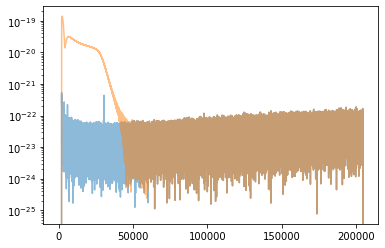

In [21]:
import bilby.gw.detector as det
import bilby.gw.waveform_generator

# set the source parameters that will define the waveform
parameters = dict(
        mass_1=samples['mass_1'][0]*10, mass_2=samples['mass_2'][0]*10, a_1=samples['a_1'][0], a_2=samples['a_2'][0], 
        tilt_1=samples['tilt_1'][0], tilt_2=samples['tilt_2'][0],
        phi_12=0., phi_jl=0., luminosity_distance=samples['dl'][0]/1000000, theta_jn=1.51, psi=1.54,
        phase=0., geocent_time=1126259642.5, ra=0, dec=0)

# set the waveform generation arguements
duration =100
sampling_frequency = 4096 # higher for higher order modes
waveform_approximant = 'IMRPhenomPv2'

waveform_arguments= dict(waveform_approximant=waveform_approximant,
                          reference_frequency=20., minimum_frequency=20., maximum_frequency=2048.)

# generate a waveform
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

# set the strain information for the detectors
ifos_list = ['H1','L1','V1']
ifos = bilby.gw.detector.networks.InterferometerList(ifos_list)
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=parameters['geocent_time'] - duration+2)

plt.plot(abs(ifos[0].frequency_domain_strain), alpha=0.5)

# inject the waveform into the detector strain data
ifo_signal = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=parameters)

plt.semilogy(abs(ifos[0].frequency_domain_strain), alpha=0.5)
# ifos[0].plot_time_domain_data() # haven't got this working

The optimal SNR has been calculated, I want to access it from the logger.

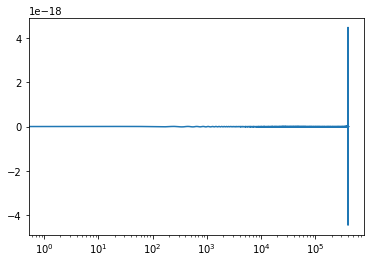

In [23]:

plt.plot(ifos[0].time_domain_strain)

In [ ]:
utils.optimal_snr_squared(signal=np.asarray(ifo_signal[0]), power_spectral_density=psd_interpolated, duration=duration)

TypeError: loop of ufunc does not support argument 0 of type dict which has no callable conjugate method

(30.0, 500.0)

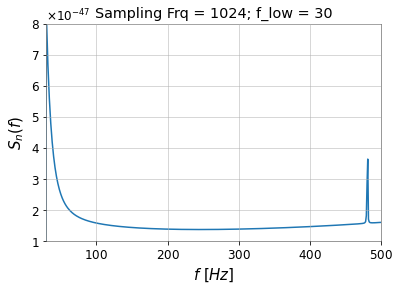

In [ ]:
def get_psd():
    fs = 1024              # Sampling frequency 
    f_low = 30             # Minimum frequency
    T_obs = 1              # Observation length in seconds
    N = T_obs * fs         # the total number of time samples
    dt = 1. / fs           # the sampling time (sec)
    df = 1. / T_obs        # the frequency resolution
    psd = lal.CreateREAL8FrequencySeries(None, lal.LIGOTimeGPS(0), 0.0, df, lal.HertzUnit, int((N / 2) + 1))
    lalsimulation.SimNoisePSDaLIGODesignSensitivityP1200087(psd, f_low)
    psd = psd.data.data
    return psd
# this is for H, and L. check how to get for virgo too

df = 1       #set sampling frequency 
f_min = 30    #10 Hz minimum frequency
psd = get_psd()
plt.plot(psd)
plt.ylabel(r'$S_{n}(f)$', fontsize=15)
plt.xlabel(r'$f \,\, [Hz]$', fontsize=15)
plt.title('Sampling Frq = '+str(1024)+ '; f_low = '+str(f_min))
plt.ylim([10**(-47), 8*10**(-47)])
plt.xlim([30, 500])

In [ ]:
def get_snr(data, T_obs, fs, psd, fmin):

    N = int(T_obs * fs)
    df = 1.0 / T_obs
    dt = 1.0 / fs
    fidx = int(fmin / df)
    win = signal.tukey(N, alpha=(1.0 / 8.0))
    idx = np.argwhere(psd > 0.0)
    invpsd = np.zeros(psd.size)
    invpsd[idx] = 1.0 / psd[idx]
    xf = np.fft.rfft(data*win)*dt
    print(xf[500])
    SNRsq = 4.0 * np.sum((np.abs(xf[fidx:]) **2 ) * invpsd[fidx:]) * df
    return np.sqrt(SNRsq)



get_snr(ht, 1, 1024, psd, 30)

ValueError: operands could not be broadcast together with shapes (262211,) (1024,) 

In [ ]:

ifos = ['H1', 'L1', 'V1']
h1 = read_frame('H-H1_LOSC_4_V2-1126259446-32.gwf', 'H1:LOSC-STRAIN')
h1 = highpass_fir(h1, 15, 8)
# Calculate the noise spectrum
psd = interpolate(welch(h1), 1.0 / h1.duration)

psd = data.psd["C01:IMRPhenomXPHM"]

# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                         f_lower=20, delta_f=1.0/h1.duration)
# with IMRPhenomXP can include other variables
hp.resize(len(h1) // 2 + 1)


# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=20.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pp.plot(snr.sample_times, abs(snr))
pp.ylabel('signal-to-noise')
pp.xlabel('GPS Time (s)')
pp.show()

XLAL Error - XLALFrStreamFileOpen (LALFrStream.c:128): No files in stream file cache
XLAL Error - XLALFrStreamFileOpen (LALFrStream.c:128): Invalid argument
XLAL Error - XLALFrStreamCacheOpen (LALFrStream.c:233): Internal function call failed: Invalid argument


RuntimeError: Internal function call failed: Invalid argument

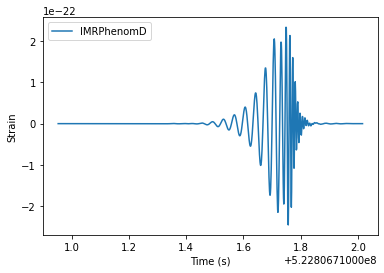

In [ ]:

from pycbc.waveform import get_td_waveform
import numpy as np
from pycbc.detector import Detector


def h_pluscross(approximant, mass1, mass2, spin1z, spin2z, distance, delta_t=1.0/2048, f_lower=30):
        hp, hc = get_td_waveform(approximant=approximant,
                                 mass1=mass1,
                                 mass2=mass2,
                                 spin1z=spin1z,
                                 spin2z=spin2z,
                                 distance=distance,
                                 delta_t=1.0/1024,
                                 f_lower=30)
        return hp, hc
    
def antenna(RA,dec,phi):
    Fp = 0.5*(1+(np.cos(dec))**2)*np.cos(2*RA)*np.cos(2*phi) + np.cos(dec)*np.sin(2*RA)*np.sin(2*phi)
    Fc = 0.5*(1+(np.cos(dec))**2)*np.cos(2*RA)*np.sin(2*phi) + np.cos(dec)*np.sin(2*RA)*np.cos(2*phi)
    
    return Fp, Fc


def h_t(hp, hc, Fp, Fc, inc):
    
    ht = hp*Fp*(1+(np.cos(inc))**2) + hc*Fc*(2*np.cos(inc))
    
    return ht

approximant =  'IMRPhenomD'

hp, hc = h_pluscross(approximant, 150, 50, 0.9, 0.5, 5500)

d = Detector("H1")
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0
time = 522806711

hp.start_time = hc.start_time = time
ht = d.project_wave(hp, hc, ra, dec, pol)

# Fp, Fc = antenna(np.pi, np.pi, 0 )
# h = h_t(hp, hc, Fp, Fc, 0.2)

times = np.array(ht.sample_times)
h = np.array(ht)[-1024:]
times=times[-1024:]

pylab.plot(ht.sample_times, ht, label=approximant)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

In [ ]:
# pycbc_condition_strain \
#     --fake-strain aLIGOAdVO4T1800545 \
#     --fake-strain-seed 1234 \
#     --fake-strain-flow 10 \
#     --sample-rate 16384 \
#     --gps-start-time 1242442818 \
#     --gps-end-time 1242442882 \
#     --channel-name V1:SIMULATED_STRAIN \
#     --injection-file injections.hdf \
#     --output-strain-file V1-SIMULATED_STRAIN-1242442818-64.gwf

SyntaxError: invalid syntax (781267114.py, line 2)

In [ ]:
# For each observatory use this template to calculate the SNR time series
snr = {}
for ifo in ifos:

    hp.resize(len(ts) / 2 + 1)
    snr[ifo] = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=25)
    snr[ifo] = snr[ifo].crop(5, 4)

In [ ]:
%matplotlib inline
import pylab
from pycbc.filter import highpass_fir
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, welch
from pycbc.catalog import Merger

for ifo in ['L1', 'H1']:
    # Read in the data into a TimeSeries
    ts = highpass_fir(Merger("GW151012").strain(ifo), 15, 16)

    # Estimate the noise spectrum
    psd = interpolate(welch(ts), 1.0 / ts.duration)
    
    # Calculate the signal-to-noise
    hp.resize(len(ts) / 2 + 1)
    snr = matched_filter(hp, ts, psd=psd, low_frequency_cutoff=30.0)

    # Choose the +-100ms around the event.
    i = int((time - snr.start_time) / snr.delta_t)
    snr = snr[int(i - snr.sample_rate * .1):int(i + snr.sample_rate * .1)]
    
    pylab.plot(snr.sample_times, abs(snr))

In [ ]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector


apx = 'SEOBNRv4'
# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
hp, hc = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         spin1z=0.9,
                         spin2z=0.4,
                         inclination=1.23,
                         coa_phase=2.45,
                         delta_t=1.0/4096,
                         f_lower=40)

det_h1 = Detector('H1')
det_l1 = Detector('L1')
det_v1 = Detector('V1')

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
end_time = 1192529720
declination = 0.65
right_ascension = 4.67
polarization = 2.34
hp.start_time += end_time
hc.start_time += end_time

signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
signal_v1 = det_v1.project_wave(hp, hc,  right_ascension, declination, polarization)

pp.plot(signal_h1.sample_times, signal_h1, label='H1')
pp.plot(signal_l1.sample_times, signal_l1, label='L1')
pp.plot(signal_v1.sample_times, signal_v1, label='V1')

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

In [ ]:
# to compare waveforms
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower


f_low = 30
sample_rate = 4096

# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant="EOBNRv2",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

sp, sc = get_td_waveform(approximant="TaylorT4",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

# Resize the waveforms to the same length
tlen = max(len(sp), len(hp))
sp.resize(tlen)
hp.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.4f}'.format(m))